# Pyro Crash Course – Notebook 7: Learning Nonlinear Drift with Neural Nets

This final notebook adds a learnable **nonlinear function** into our probabilistic model. We use an **artificial neural network (ANN)** to model a shared drift that affects all measurements, extending the expressive power of our calibration framework.

---

### 🔙 Quick Recap
Notebook 6 allowed each sensor to be classified as faulty or functioning, introducing discrete latent variables and structured priors per class. 

Now we go a step further: we assume that all devices experience some unknown nonlinear drift, perhaps due to an environmental factor not captured in the model. We use a neural network to learn this drift directly from the data—while still performing joint inference over:
 - Per-device scale and offset (`alpha`)
 - Device failure mode (`is_faulty`)
 - Shared nonlinear trends (`ANN(T_true)`)
 
---

### 🎯 Learning Goals

- Add a neural network to a Pyro model using torch.nn and pyro.module
- Treat ANN parameters as deterministic learnable components
- Combine continuous, discrete, and functional unknowns in a single model
- Interpret the learned ANN as a shared, nonlinear correction to the measured data
- Train models that resemble real calibration setups with subtle unknown effects

---

### 🛠 Modeling Idea

We assume each measurement is generated as:

$$
T_{\text{meas}} = \alpha_0 + \alpha_1 \cdot T_{\text{true}} + \text{ANN}(T_{\text{true}}) + \varepsilon
$$

Where:

- $\alpha_0, \alpha_1$ are **latent calibration parameters per device**
- $\text{ANN}(T_{\text{true}})$ is a **shared nonlinear drift**
- $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ is i.i.d. measurement noise
- Devices may be **faulty**, in which case their calibration parameters are drawn from broader priors

We treat the ANN as a fixed function during inference, but let its parameters be **optimized via the ELBO**—just like in classical machine learning.



For this, do the following:
   1. Imports and definitions  
   2. Build model and guide  
   3. Perform inference  
   4. Interpretations and illustrations


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/atlasoptimization/tutorials/blob/master/pyro/pyro_crash_course/pyro_cc_7_model_5.ipynb
)

> ⚠️ You do *not* need to sign in with GitHub to run this notebook.  
> Just click the Colab badge and start executing.

📎 Input: `sensor_measurements.csv` (generated in `pyro_cc_1_hello_dataset`) 

📌 This is the **final notebook** of the pyro crash course!


This notebook and series are created for educational purposes by  [Dr. Jemil Avers Butt, Atlas Optimization GmbH](https://www.atlasoptimization.com).


---

# Start of Notebook 7

## 1. Imports and definitions

No changes here. Just setup — `pyro`, `torch`, CSV import, reshaping, and seed.


📌 This is the final notebook. It **introduces neural nets** to our probabilistic models.


In [1]:
"""
    1. Imports and definitions
"""

# i) Imports
# If you run this in Colab, you might get an import error as pyro is not
# installed by default. In that case, uncomment the following command.
# !pip install pyro-ppl

import pyro
import torch
import pandas
import matplotlib.pyplot as plt
from pyro.infer import config_enumerate


# ii) Definitions
!wget https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
measurement_df = pandas.read_csv("sensor_measurements.csv")
n_device = measurement_df["sensor_id"].nunique()
n_measure = measurement_df["time_step"].nunique()

# Read out T_true and T_meas: the true temperature and the measured temperature
T_true = torch.tensor(measurement_df["T_true"].values).reshape(n_device, n_measure)
T_meas = torch.tensor(measurement_df["T_measured"].values).reshape(n_device, n_measure)

# Assume standard deviation
sigma_T_meas = 0.3

# Fix random seed
pyro.set_rng_seed(0)


--2025-05-13 14:57:25--  https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12270 (12K) [text/plain]
Saving to: ‘sensor_measurements.csv.1’

sensor_measurements 100%[===================>]  11.98K  --.-KB/s    in 0s      

2025-05-13 14:57:25 (48.7 MB/s) - ‘sensor_measurements.csv.1’ saved [12270/12270]



---

# 2. Build model and guide

## 🔧 Model Specification

We extend the hierarchical model from Notebook 6 by including a shared **nonlinear drift** term modeled by a neural network. This shared component captures global trends across all devices and is trained jointly with the latent variables.

Each sensor is still either:

- ✅ **Functioning normally**: Parameters drawn from `𝒩([0, 1], Σ)`
- ❌ **Faulty**: Parameters drawn from `𝒩([0, 1], Σ_faulty)` with much larger uncertainty

As before, each device has a discrete latent variable:

$$
\text{is_faulty}_i \sim \text{Bernoulli}(p_\text{faulty})
$$

The covariance of the calibration prior depends on faultiness:

$$
\Sigma_{\text{device},i} = \Sigma_{\text{normal}} + \text{is_faulty}_i \cdot (\Sigma_{\text{faulty}} - \Sigma_{\text{normal}})
$$

The calibration parameters (offset and scale) are sampled per device:

$$
\alpha_i \sim \mathcal{N}(\mu_\alpha, \Sigma_{\text{device},i})
\quad \text{where} \quad
\mu_\alpha = \begin{bmatrix} 0 \\ 1 \end{bmatrix}
$$


### Shared Nonlinear Drift

On top of this per-device affine structure, we introduce a shared **neural network drift** `ANN(T_true)` that adjusts the predicted value globally:

$$
T_{\text{meas}}[i,j] \sim \mathcal{N} \left(
    \alpha_{i,0} + \alpha_{i,1} \cdot T_{\text{true}}[i,j] + \text{ANN}(T_{\text{true}}[i,j]),
    \sigma_\text{Tmeas}
\right)
$$

The drift function `ANN` is implemented via a PyTorch neural network. Unlike the device-specific `α`, which vary across sensors, the neural net learns a **global nonlinear correction** shared by all sensors. This allows Pyro to:

- Capture smooth distortions in temperature behavior
- Avoid hardcoding the structure of the drift
- Automatically learn patterns not explainable by offsets or scale

The drift function is fully differentiable and fits naturally into the SVI framework.



---

## 2.1 Define the ANN

We define a **small feedforward neural network** that learns a global nonlinear drift correction over all temperature measurements. It's used as an additive term in the model:

$$
T_{\text{meas}} \approx \text{offset} + \text{scale} \cdot T_{\text{true}} + \text{ANN}(T_{\text{true}})
$$

### 🔧 Architecture

- **Input:** scalar `T_true[i,j] ∈ ℝ`  
- **Output:** scalar drift adjustment for each `[i,j]`  
- **Layers:**
  - `Linear(1 → 8)` + `Tanh`
  - `Linear(8 → 8)` + `Tanh`
  - `Linear(8 → 1)`

### 🔍 Purpose

- Captures **global nonlinear trends** shared across all sensors
- Complements the **per-device linear calibration model**
- Is treated as a deterministic function with trainable parameters, optimized via ELBO

### ✅ Notes

- The network is built as a subclass of `torch.nn.Module`
- Registered via `pyro.module("ann", ann)` to ensure parameters are included in optimization


In [2]:
# i) Define the ANN)
class ANN(torch.nn.Module):
    def __init__(self):
        # Initialize instance using init method from base class
        super().__init__()
        
        # Create linear and nonlinear transforms
        self.lin_1 = torch.nn.Linear(1,8)
        self.lin_2 = torch.nn.Linear(8,8)
        self.lin_3 = torch.nn.Linear(8,1)
        self.nonlinear = torch.nn.Tanh()
    def forward(self, t):
        # Define forward computation on the input data T_true.
        t = t.reshape([-1, 1])
        hidden_units_1 = self.nonlinear(self.lin_1(t))
        hidden_units_2 = self.nonlinear(self.lin_2(hidden_units_1))
        nonlinear_drift = self.lin_3(hidden_units_2)
        
        nonlinear_drift = nonlinear_drift.reshape([n_device, n_measure])
        return nonlinear_drift
    

### 🧠 Neural Networks in Pyro

Neural networks can serve as powerful nonlinear function approximators inside probabilistic models. In Pyro, you can treat them as deterministic modules with learnable parameters — useful for modeling **unknown systematics**, **sensor drift**, **nonlinear response functions**, and more.

Suppose we model an observation $y$ as:

$$
y  \approx \text{ANN}(x) + \varepsilon
$$

Here, the neural network learns a data-driven **nonlinear mapping** to map $x$ to $y$. We showcase below an example of how ANN's are built in pyro and then integrated into pyro models. Typically, this involves three steps:

- Define a class ANN and the layers to be used (subclass torch.nn.Module and use torch.nn differentiable layers)
- Define the ANN classes forward() method by chaining the layers (= forward pass of the ANN)
- Invoke an instance of ANN and register it inside of the model via pyro.module() (= mark params for optimization)

---

### ✅ Minimal Pyro Pattern

```python
import torch
import pyro

# 1. Define ANN (standard torch.nn API works fine)
class ANN(torch.nn.Module):
    def __init__(self):
        # Initialize instance using init method from base class
        super().__init__()
        
        # transforms: linear, nonlinear
        self.lin_1 = torch.nn.Linear(1,64)
        self.lin_2 = torch.nn.Linear(64,1)
        self.nonlinear = torch.nn.Tanh()
        
    def forward(self, x):
        # Reshape, then define how to chain the operations on input x
        x = x.reshape([-1, 1])
        hidden_units = self.nonlinear(self.lin_1(x))
        nonlinear_drift = self.lin_2(hidden_units)
        return nonlinear_drift

# 2. Instantiate, then use as normal differentiable function
ann = ANN()
x_example = torch.linspace(0,1,100)
y = ann(x_example)

def model(x, y_obs=None):
    pyro.module("ann", ann)  # <- register all trainable params
    # ... rest of model


## 2.2 Define model and guide

The subsequent code for model and guide are essentially identical to the code provided in the previous notebook. The only differences are marking the params inside of the ann for optimization (via `pyro.module("ann", ann)`) and adding the neural network term to the mean (via `mean_obs = ... + ann(input_vars`)).


In [3]:
# ii) Define the model

# Define priors and fixed params
mu_alpha = torch.tensor([0.0, 1.0]).expand(n_device, -1)
Sigma_alpha = torch.tensor([[0.1**2,0], [0, 0.1**2]])
p_faulty = 0.05
Sigma_faulty = 100*Sigma_alpha

# Now instantiate the neural net ann; set the params to double to match the data
ann = ANN().double()

# Build the model in pyro; just mix in ann() like any normal torch function
@config_enumerate
def model(input_vars = T_true, observations = None):
    # Mark the parameters inside of the ann for optimization
    pyro.module("ann", ann)
    
    # Build reusable independence context device_plate and sample
    device_plate = pyro.plate('device_plate', size=n_device, dim=-1)
    with device_plate:
        is_faulty = pyro.sample('is_faulty', pyro.distributions.Bernoulli(p_faulty))
    is_faulty_tensor = is_faulty.unsqueeze(-1).unsqueeze(-1)

    # Build alpha_dist and sample
    Sigma_device = Sigma_alpha + is_faulty_tensor * (Sigma_faulty - Sigma_alpha)  # shape: [n_device, 2, 2]
    alpha_dist = pyro.distributions.MultivariateNormal(
        loc=mu_alpha,                   # shape: [2, n_device, 2]
        covariance_matrix=Sigma_device)     # shape: [2, n_device, 2, 2]
    with device_plate:
        alpha = pyro.sample("alpha", alpha_dist)
        
    # Build observation dist and sample
    mean_obs = alpha[:, 0].unsqueeze(1) + alpha[:, 1].unsqueeze(1) * T_true + ann(input_vars)
    obs_dist = pyro.distributions.Normal(loc=mean_obs, scale=sigma_T_meas)
    with pyro.plate('device_plate', dim=-2):
        with pyro.plate('measure_plate', dim=-1):
            pyro.sample("observations", obs_dist, obs=observations)
            

In [4]:
# ii) Build the guide
@config_enumerate
def guide(input_vars = T_true, observations = None):
    # Build plate and sample is_faulty
    device_plate = pyro.plate('device_plate', size=n_device, dim=-1)
    probs_faulty = pyro.param("probs_faulty", 0.05 * torch.ones(n_device),
                              constraint=pyro.distributions.constraints.unit_interval)
    with device_plate:
        is_faulty = pyro.sample("is_faulty", pyro.distributions.Bernoulli(probs_faulty))
    
    # Per-device means and scales (shape [n_device, 2])
    mu_alpha_post = pyro.param('mu_alpha_post', torch.tensor([0,1.0]).unsqueeze(0).expand([n_device,2]))
    sigma_alpha_post = (pyro.param('sigma_alpha_post', 0.1 * (torch.eye(2).unsqueeze(0)).expand([n_device,2,2]),
                              constraint=pyro.distributions.constraints.positive_definite) 
                        + 0.001 * torch.eye(2))
    
    # Sample alpha
    with device_plate:
        # Multivariate Gaussian for each device (allow for correlations)
        alpha = pyro.sample('alpha', pyro.distributions.MultivariateNormal(loc = mu_alpha_post,
                                        covariance_matrix = sigma_alpha_post))
    return alpha, is_faulty


## 📐 Tensor Shapes Table

| Variable              | Shape                   | Description |
|-----------------------|--------------------------|-------------|
| `T_true`              | `[n_device, n_measure]`   | True temperature values (input) |
| `T_meas`              | `[n_device, n_measure]`   | Observed noisy measurements |
| `alpha`               | `[n_device, 2]`           | Offset and scale per device |
| `mu_alpha_post`       | `[n_device, 2]`           | Posterior means of `alpha` |
| `sigma_alpha_post`    | `[n_device, 2, 2]`        | Posterior covariances of `alpha` |
| `is_faulty`           | `[n_device]`              | Binary latent variable for each device |
| `Sigma_device`        | `[n_device, 2, 2]`        | Covariance matrix (depends on `is_faulty`) |
| `posterior_faulty`    | `[n_samples, n_device]`   | Posterior samples of `is_faulty` |
| `ann(T_true)`         | `[n_device, n_measure]`   | Global nonlinear drift (shared) |

Purely structurally, the addition of the ANN changes very little in our model. We simply have one more function whose parameters need training. We illustrate the overall model below. You will be able to see the inclusion of multiple new parameters called `ann$$$lin__1.weight` and similar - they represent the inside of the neural network.


In [5]:
# iii) Illustrate model and guide
# Now the illustration of the model shows additional parameters representing the
# biases and weights of the linear layers in the neural network. The guide looks
# the same as before.
graphical_model = pyro.render_model(model = model, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)
graphical_guide = pyro.render_model(model = guide, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)


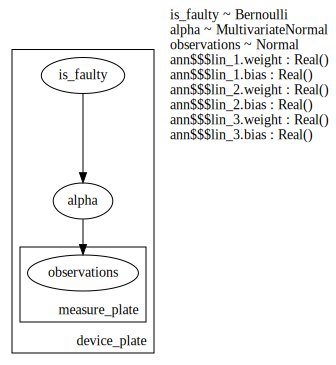

In [6]:
graphical_model

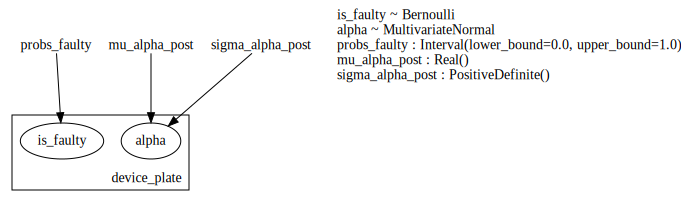

In [7]:
graphical_guide

In [8]:
# iv) Record example outputs of model and guide prior to training
n_model_samples = 10
n_guide_samples = 1000  

predictive = pyro.infer.Predictive
prior_predictive_pretrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_pretrain = predictive(guide, num_samples = n_guide_samples)()['alpha']
posterior_pretrain_faulty = predictive(guide, num_samples = n_guide_samples)()['is_faulty']
posterior_predictive_pretrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']


---

# 3. Perform inference

## 🧠 Inference with Discrete Latents and Neural Networks

To train the model, we minimize the **Evidence Lower Bound (ELBO)** using stochastic variational inference:

$$
\text{ELBO} = \mathbb{E}_{q_\phi(z)}[\log p(x, z) - \log q_\phi(z)]
$$

Our model now includes:

- Discrete latent variables (`is_faulty`)  
- Continuous latent variables (`alpha`)  
- Learnable parameters from a neural network (`ann`)  

We use:

- `TraceEnum_ELBO` to **enumerate** over the discrete latent variables
- Monte Carlo sampling (`num_particles > 1`) for the continuous latents
- Gradient-based learning for the neural net weights

This enables us to **jointly learn**:
- The per-device calibration parameters  
- The probability of each device being faulty  
- A shared **nonlinear drift function** across all devices  


In [9]:
"""
    3. Perform inference
"""

# i) Set up inference
adam = pyro.optim.Adam({"lr": 0.01})
elbo = pyro.infer.TraceEnum_ELBO(num_particles = 10,
                                 max_plate_nesting = 2)
svi = pyro.infer.SVI(model, guide, adam, elbo)


# ii) Perform svi

data = (T_true, T_meas)
loss_sequence = []
for step in range(3000):
    loss = svi.step(*data)
    loss_sequence.append(loss)
    if step %50 == 0:
        print(f'epoch: {step} ; loss : {loss}')


epoch: 0 ; loss : 53707.7534308528
epoch: 50 ; loss : 29297.56991749781
epoch: 100 ; loss : 19321.89543800371
epoch: 150 ; loss : 13025.876104981562
epoch: 200 ; loss : 10747.238108977483
epoch: 250 ; loss : 6785.122517551263
epoch: 300 ; loss : 7692.150914395468
epoch: 350 ; loss : 5003.652629845844
epoch: 400 ; loss : 4657.5006386023515
epoch: 450 ; loss : 4115.925911569804
epoch: 500 ; loss : 3099.9811012303167
epoch: 550 ; loss : 4025.54692285314
epoch: 600 ; loss : 3537.755214095899
epoch: 650 ; loss : 2999.8426709492965
epoch: 700 ; loss : 3389.9496346707338
epoch: 750 ; loss : 2402.21116471476
epoch: 800 ; loss : 2253.8049590362116
epoch: 850 ; loss : 2825.2036658646384
epoch: 900 ; loss : 2377.1419803307413
epoch: 950 ; loss : 2421.2894027985976
epoch: 1000 ; loss : 1862.4557146664877
epoch: 1050 ; loss : 1824.4013392658358
epoch: 1100 ; loss : 1549.0122874880526
epoch: 1150 ; loss : 2529.029961059539
epoch: 1200 ; loss : 1723.998974197058
epoch: 1250 ; loss : 1490.559191199594

📌 Learning the neural drift is challenging:  
Increasing `num_particles` improves accuracy but may get stuck in local minima. Instead, we lower `num_particles` and train longer to encourage **model space exploration**. As a downside, running this cell might take 15 mins! This is the right point in time to already skip ahead with reading the summary and condensing the whole of the crash course for yourself.

Note that training not converging may not always be due to the problem just being too hard - sometimes some subtle bugs can worm their way into the code. You can see some listed below. Especially notice that not calling `pyro.module()` to register the parameters inside of the ANN results in no training being done at all on the ANN parameters. This might not even be recognizable in the loss. 
 

## ⚠️ Troubleshooting Checklist

| Symptom                      | Likely Cause                        | Fix                                                          |
| ---------------------------- | ----------------------------------- | ------------------------------------------------------------ |
| Parameters don't change      | `pyro.module()` is missing          | Add `pyro.module("ann", ann)` inside `model()`               |
| Gradients are `None` or zero | Model is disconnected from data     | Ensure `ann(x)` influences `obs`                             |
| "Parameter already exists"   | Re-running cells in Jupyter         | Use `pyro.clear_param_store()`                               |
| Dtype mismatch errors        | Mixed float32 / float64 tensors     | Use `torch.set_default_dtype(torch.float64)` and `.double()` |
| Learning is unstable or flat | Poor init, too deep network, low LR | Try smaller network, warm-up, check signal-to-noise          |


In [10]:
# iii) Record example outputs of model and guide after training
prior_predictive_posttrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_posttrain = predictive(guide, num_samples = n_guide_samples)()['alpha']
posterior_posttrain_faulty = predictive(guide, num_samples = n_guide_samples)()['is_faulty']
posterior_predictive_posttrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']

# iv) Additional investigations
model_trace = pyro.poutine.trace(model).get_trace(T_true, observations = T_meas)
guide_trace = pyro.poutine.trace(guide).get_trace(T_true, observations = T_meas)
print('These are the shapes inside of the model : \n {}'.format(model_trace.format_shapes()))
print('These are the shapes inside of the guide : \n {}'.format(guide_trace.format_shapes()))

# The parameters of the posterior are again stored in pyro's param_store
for name, value in pyro.get_param_store().items():
    print('Param : {}; Value : {}'.format(name, value))

# Estimate the posterior probabilities of each device being faulty. 
faulty_pretrain = torch.mean(posterior_pretrain_faulty,dim=0)
faulty_posttrain = torch.mean(posterior_posttrain_faulty,dim=0)
print('is_faulty ground truth : [1, 0, 0, 0, 0]')
print('Probabilities of being faulty pre-training : {} \n'
      'Probabilities of being faulty post-training : {} '
      .format(faulty_pretrain, faulty_posttrain))


These are the shapes inside of the model : 
      Trace Shapes:          
      Param Sites:          
ann$$$lin_1.weight     8 1  
  ann$$$lin_1.bias       8  
ann$$$lin_2.weight     8 8  
  ann$$$lin_2.bias       8  
ann$$$lin_3.weight     1 8  
  ann$$$lin_3.bias       1  
     Sample Sites:          
 device_plate dist       |  
             value     5 |  
    is_faulty dist     5 |  
             value     5 |  
        alpha dist     5 | 2
             value     5 | 2
 observations dist 5 100 |  
             value 5 100 |  
These are the shapes inside of the guide : 
     Trace Shapes:        
     Param Sites:        
     probs_faulty     5  
    mu_alpha_post   5 2  
 sigma_alpha_post 5 2 2  
    Sample Sites:        
device_plate dist     |  
            value   5 |  
   is_faulty dist   5 |  
            value   5 |  
       alpha dist   5 | 2
            value   5 | 2
Param : ann$$$lin_1.weight; Value : Parameter containing:
tensor([[-0.0478],
        [-0.1240],
        [

---

# 4. Illustrations and interpretations

We visualize:

- The loss decrease during training
- The estimated nonlinear drift function
- Raw data alongside generated model outputs

This provides immediate insight into how well the model fits each sensor and what the ANN contributes towards modelling the sensor data.


In [ ]:
"""
    4. Interpretations and illustrations
"""

# i) Plot and print ELBO loss
plt.figure(1, dpi = 300)
plt.plot(loss_sequence)
plt.yscale("log")
plt.title('ELBO loss during training (log scale)')
plt.xlabel('Epoch nr')
plt.ylabel('value')


In [ ]:
# ii) Showcase the nonlinear drift

# SVI adjusted the parameters in the neural net such that the ELBO was reduced.
plt.figure(2, dpi = 300)
plt.plot(ann(T_true).detach().T)
plt.title('Learned drift function')
plt.xlabel('T_true')
plt.ylabel('Drift value')


In [ ]:

# iii) Compare model output and data

# Create the figure and 2x5 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=False, sharey=False)
# Global y-axis limits
y_min = T_meas.min()
y_max = T_meas.max()

# FIRST ROW
# First plot: measurement data
for i in range(n_device):
    axes[0,0].scatter(T_true[i,:], T_meas[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,0].set_title("Measurement data")
axes[0,0].set_xlabel("T_true")
axes[0,0].set_ylabel("T_meas")
axes[0,0].set_ylim(y_min, y_max)
axes[0,0].legend()

# Second plot: data produced by model pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,1].scatter(T_true[i,:], prior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,1].set_title("Data from model pre-training")
axes[0,1].set_xlabel("T_true")
axes[0,1].set_ylabel("T_meas")
axes[0,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,2].scatter(T_true[i,:], posterior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,2].set_title("Data from posterior predictive pre-training")
axes[0,2].set_xlabel("T_true")
axes[0,2].set_ylabel("T_meas")
axes[0,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide pre-training
axes[0,3].hist2d(posterior_pretrain[:,:,0].flatten().numpy(),
                 posterior_pretrain[:,:,1].flatten().numpy(),
                 bins=10, cmap='viridis')
axes[0,3].set_title("2D Histogram of parameters pre-train")
axes[0,3].set_xlabel("alpha_0")
axes[0,3].set_ylabel("alpha_1")

# SECOND ROW
# Second plot: data produced by model post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,1].scatter(T_true[i,:], prior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,1].set_title("Data from model post-training")
axes[1,1].set_xlabel("T_true")
axes[1,1].set_ylabel("T_meas")
axes[1,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,2].scatter(T_true[i,:], posterior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,2].set_title("Data from posterior predictive post-training")
axes[1,2].set_xlabel("T_true")
axes[1,2].set_ylabel("T_meas")
axes[1,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide post-training
axes[1,3].hist2d(posterior_posttrain[:,:,0].flatten().numpy(),
                 posterior_posttrain[:,:,1].flatten().numpy(),
                 bins=10, cmap='viridis')
axes[1,3].set_title("2D Histogram of parameters post-train")
axes[1,3].set_xlabel("alpha_0")
axes[1,3].set_ylabel("alpha_1")

plt.tight_layout()
plt.show()


## 🧾 Summary

In this notebook, we:

✅ Built a full probabilistic model with **continuous, discrete, and neural components**  
✅ Introduced a **shared nonlinear drift**, modeled by a neural network (`ann`)  
✅ Combined this with **per-device latent calibration parameters** and **outlier detection**  
✅ Trained all components using **stochastic variational inference** and `TraceEnum_ELBO`  
✅ Visualized how the model recovers **nonlinear effects and faulty devices** from data


📌 This concludes our crash course in Pyro!

With tools like:
- Latent variable modeling (both discrete and continuous)
- Hierarchical priors and structured plates
- Inference over neural networks

you’re now ready to tackle **real-world probabilistic modeling** problems — from calibration to forecasting to anomaly detection.

🎉 Thanks for following along!
